<a href="https://colab.research.google.com/github/yingzibu/PBPK/blob/main/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: Bootstrap confidence intervals: when, which, what? A practical guide for medical statisticians

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [130]:
# Table 2 data
data_df = pd.DataFrame()
data_df['birthweight(oz)'] = pd.DataFrame([72,112,111,107,119,92,126,80,81,84,115,118,128,128])
data_df['weight at 70-100 days(oz)'] = pd.DataFrame([121,183,184,184,181,161,222,174,178,180,148,168,189,192])
N = len(data_df) # data size, 14
col_0_name = data_df.columns[0]
col_1_name = data_df.columns[1]
data_df

,birthweight(oz),weight at 70-100 days(oz)
0,72,121
1,112,183
2,111,184
3,107,184
4,119,181
5,92,161
6,126,222
7,80,174
8,81,178
9,84,180


In [148]:
# numpy: y = mx + c approximation
linear_relation = np.polyfit(data_df[data_df.columns[0]],
                             data_df[data_df.columns[1]], 1)
print('numpy approximation:', linear_relation)
# optimize.curve_fit from scipy
from scipy import optimize
def func(x, a, b):
    y = a*x + b
    return y
alpha = optimize.curve_fit(func, xdata = data_df[col_0_name], ydata = data_df[col_1_name])[0]
print('scipy approximation:', alpha)

numpy approximation: [  0.67842153 104.69179179]
scipy approximation: [  0.67842153 104.69179179]


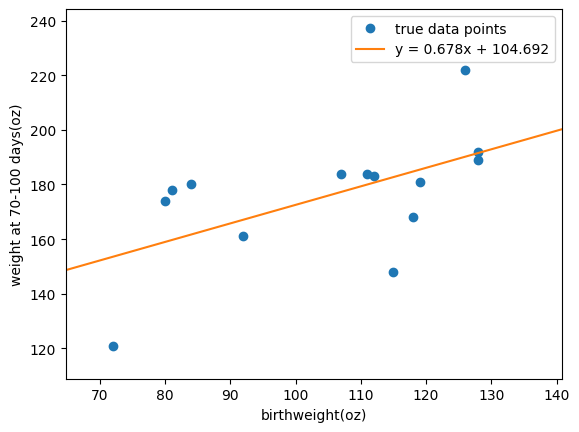

In [132]:
plt.plot(data_df[data_df.columns[0]],data_df[data_df.columns[1]], 'o',
         label='true data points')
plt.xlabel(data_df.columns[0])
plt.ylabel(data_df.columns[1])

x_range = [data_df[data_df.columns[0]].min()*0.9,
           data_df[data_df.columns[0]].max()*1.1]
y_range = [data_df[data_df.columns[1]].min()*0.9,
           data_df[data_df.columns[1]].max()*1.1]

xs = np.linspace(x_range[0].round()-1, x_range[1]+1, 100)
ys = linear_relation[0] * xs + linear_relation[1]
# plot linear approximation 70-100day weight = alpha + beta * birthweight
plt.plot(xs, ys,
         label=f'y = {linear_relation[0]:.3f}x + {linear_relation[1]:.3f}')
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.show()

## Non-parametric resampling
"Non-parametric resampling makes no assumptions concerning the distribution of, or model for the data"

1. Sample n cases randomly __with replacement__ to obtain a bootstrap data set
2. Fit the linear model to the bootstrap data and obtain the bootstrap slope $\hat{\beta}^*$.
3. Repeat step 1 and 2 a large number, say B, of times to obtain an estimate of the bootstrap distribution

In [59]:
B = 999
beta_estimates = []
for i in tqdm(range(B), total=B, desc=f'sample {B} times'): # step 3, repeat B times
    bootstrap_data = data_df.sample(n=N, replace=True) # step 1, sample n cases with replacement
    lr_here = np.polyfit(bootstrap_data[data_df.columns[0]],
                         bootstrap_data[data_df.columns[1]], 1) # fit linear model
    beta_estimates.append(lr_here[0]) # obtain the slope beta and append to a list

beta_estimates.sort() # sort beta list based on value


sample 999 times: 100%|██████████| 999/999 [00:00<00:00, 1563.20it/s]


## Parametric sampling

1. Draw $n$ observations, $z_1, \cdots, z_n$, from the $\mathcal{N}(0, \sigma^2)$ distribution
2. Calculate bootstrap responses, $y_i^*$, as $y_i^* = \hat{\alpha} + \hat{\beta}x_i + z_i, i \in 1, \cdots, n$. The bootstrap data set then consists of the n pairs of $(y_i^*, x_i)$
3. Calculate the boostrap slope $\hat{\beta}^*$, as the least squares regression slope for this bootstrap data set.
4. Repeat 1-3 B times to obtain an estimate of the parametric bootstrap distribution.

In [133]:
# estimated_weight = a + b * birthweight
def estimated_weight(birthweight,
                     a = linear_relation[1],
                     b = linear_relation[0]):
    return a + b * birthweight

def cal_error(df):
    # print(df)
    # print(df.name)
    col_0 = df[col_0_name]
    col_1 = df[col_1_name]
    # print(col_0, col_1)
    return col_1 - estimated_weight(col_0)
data_df['estimation'] = data_df[col_0_name].apply(estimated_weight)
data_df['error'] = data_df.apply(cal_error, axis=1)
data_df

,birthweight(oz),weight at 70-100 days(oz),estimation,error
0,72,121,153.538142,-32.538142
1,112,183,180.675003,2.324997
2,111,184,179.996582,4.003418
3,107,184,177.282896,6.717104
4,119,181,185.423954,-4.423954
5,92,161,167.106573,-6.106573
6,126,222,190.172905,31.827095
7,80,174,158.965514,15.034486
8,81,178,159.643936,18.356064
9,84,180,161.679200,18.320800


In [139]:
# papers variance sigma^2 is 14.1, which is not true. I think it should be sigma = 14.1
# yet my calculation is ~18
sigma_ddof_0 = data_df.std(ddof=0)['error']
sigma_ddof_1 = data_df.std(ddof=1)['error']
print(f'papers sigma: 14.1, different from my calculation')
print(f'my calculation | ddof=0: {sigma_ddof_0:.3f} | ddof=1: {sigma_ddof_1:.3f}')

papers sigma: 14.1, different from my calculation
my calculation | ddof=0: 18.098 | ddof=1: 18.781


In [134]:
# Draw from N(0, sigma^2)
mu, sigma = 0, 14.1 # mean and standard deviation

# input should be sigma instead of variance, yet this follows N(0, sigma^2)
z = np.random.normal(0, sigma, N) # why input is sigma instead of sigma ** 2, confusing

In [149]:
B = 999
beta_estimates = []
sigma = 14.1 # use paper's sigma
df = data_df.copy()

for i in tqdm(range(B), total=B, desc=f'sample {B} times'): # step 4, repeat B times
    z = np.random.normal(0, sigma, N) # step 1, draw n observations from the Normal distribution
    df['z'] = z
    df['y_star'] = df.apply(lambda x: x['estimation']+x['z'], axis=1) # step 2, y_i*=α+β x_i+z_i
    lr_here = np.polyfit(df[col_0_name], df['y_star'], 1) # step 3, calculate the bootstrap slope
    beta_estimates.append(lr_here[0]) # obtain the slope beta and append to a list

beta_estimates.sort() # sort beta list based on value


sample 999 times: 100%|██████████| 999/999 [00:00<00:00, 1029.85it/s]


## Semi-parametric resampling

Having obtained the least squares exstimates of $\hat{\alpha}$ and $\hat{\beta}$, we calculate the residuals as

$$r_i = y_i - \hat{\alpha} - \hat{\beta} x_i, i \in 1, \cdots, n$$

Let $\bar{r} = \sum_{i=1}^n r_i / n$, the mean of the residuals, and let $\tilde{r}_i = r_i - \bar{r}, r=1, \cdots, 14$. We then proceed as follows:
1. Sample from the set of adjusted residuals, $\tilde{r}_i, i \in 1, \cdots, n$, randomly with replacement, so obtaining $r_1^*, \cdots, r_n^*$
2. Then calculate the bootstrap data as

$$y_i^* = \hat{\alpha} + \hat{\beta} x_i + r_i^*, i \in 1, \cdots, n$$


3. Fir the linear model to the bootstrap data $(y_i^*, x_i)$, obtaining $\hat{\beta}^*$
4. Repeat steps 1-3 B times to obtain an estimate of the bootstrap distribution.

In [215]:
B = 999
beta_estimates = []

r_bar = data_df['error'].mean(axis=0)
data_df['r_tilde'] = data_df.apply(lambda x: x['error']-r_bar, axis=1)
df = data_df.copy()

for i in tqdm(range(B), total=B, desc=f'sample {B} times'): # step 4, repeat B times
    bootstrap_r = data_df['r_tilde'].sample(n=N, replace=True) # step 1, sample n residuals with replacement
    bootstrap_r = bootstrap_r.reset_index(drop=True)
    df['bootstrap_r'] = pd.DataFrame(bootstrap_r)
    df['bootstrap_y'] = df.apply(lambda x: x['estimation']+x['bootstrap_r'],
                                 axis=1) # step 2, calculate the bootstrap data
    lr_here = np.polyfit(df[col_0_name], df['bootstrap_y'], 1) # fit linear model
    beta_estimates.append(lr_here[0]) # obtain the slope beta and append to a list

beta_estimates.sort() # sort beta list based on value


sample 999 times: 100%|██████████| 999/999 [00:01<00:00, 636.89it/s]


In [217]:

len(beta_estimates)

999